# Web Scraping Project

### ที่มาและความสำคัญ

ร้านขายหนังสือออนไลน์สตาร์ทอัพต้องการเลือกสต็อกหนังสือที่มีแนวโน้มขายดีตามแนวโน้มของตลาดในปัจจุบัน เป้าหมายคือการเพิ่มผลตอบแทนจากการลงทุนเบื้องต้น

# ขั้นตอนที่ 1 การดึงข้อมูลจาก (WebScraping)

In [19]:
# Import necessary libraries
from urllib.request import urlopen as uReq
from bs4 import BeautifulSoup as soup
import pandas as pd

# Variable to store website link as string
myurl = 'http://books.toscrape.com/catalogue/page-{}.html'
base_url = 'http://books.toscrape.com/catalogue/'

# Create empty lists to store book details (define them outside the loop)
book_titles = []
book_prices = []
book_genre = []
book_rating = []
book_Stock_Status = []
book_reviews = []

# Loop through pages 1 to 50
for i in range(1, 51):
    # Grab website and store in variable uclient
    uClient = uReq(myurl.format(i))
    
    # Read and close HTML
    page_html = uClient.read()
    uClient.close()
    
    # Call BeautifulSoup for parsing
    page_soup = soup(page_html, "html.parser")
    
    # Grabs all the products under list tag
    bookshelf = page_soup.findAll("li", {"class": "col-xs-6 col-sm-4 col-md-3 col-lg-3"})
    
    for books in bookshelf:
        # Collect title of all books
        book_title = books.h3.a["title"]
        
        # Collect book price of all books
        book_price = books.findAll("p", {"class": "price_color"})
        price = book_price[0].text.strip()
    
        # Collect genre of all books
        url_book_genre_parser = books.h3.a["href"]
        full_url_book_genre_parser = base_url + url_book_genre_parser.replace("../", "")  # Create the full URL
    
        # Open the book's page and parse it
        uClient_genre = uReq(full_url_book_genre_parser)
        url_page = uClient_genre.read()
        uClient_genre.close()
    
        # Call BeautifulSoup for parsing
        url_soup = soup(url_page, "html.parser")
    
        # Initialize genre with a default value in case breadcrumb is not found
        genre = "Unknown"
        
        # Grabs the product's genre
        breadcrumb = url_soup.find("ul", {"class": "breadcrumb"})
        if breadcrumb:
            genre = breadcrumb.findAll("li")[2].a.text.strip()
    
        # Find the number of reviews in the table
        book_reviews_count = "N/A"  # Default value if not found
        reviews_count = url_soup.find("table", {"class": "table table-striped"})
        if reviews_count:
            reviews_th = reviews_count.find("th", string="Number of reviews")
            if reviews_th:
                book_reviews_count = reviews_th.find_next_sibling("td").text.strip()
        
        # Get book rating
        book_star = books.p["class"][1].lower()
        if book_star == "one":
            rating = 1
        elif book_star == "two":
            rating = 2
        elif book_star == "three":
            rating = 3
        elif book_star == "four":
            rating = 4
        else:
            rating = 5
    
        # Get stock status
        book_Status = books.find("div", {"class": "product_price"})
        book_Stock = "N/A"  # Default value
        if book_Status:
            stock_info = book_Status.find("p", {"class": "instock availability"})
            if stock_info:
                book_Stock = stock_info.text.strip()
    
        # Append the collected data to lists
        book_titles.append(book_title)
        book_prices.append(price)
        book_genre.append(genre)
        book_rating.append(rating)
        book_Stock_Status.append(book_Stock)
        book_reviews.append(book_reviews_count)

# Create a pandas DataFrame to hold the collected data
books_df = pd.DataFrame({
    'Genre': book_genre,
    'Book Title': book_titles,
    'Price': book_prices,
    'Rating': book_rating,
    'Stock Status': book_Stock_Status,
    'Number of Reviews': book_reviews
})

# Save the dataframe as a CSV file
books_df.to_csv("Books.csv", index=False)

# Display the dataframe
print(books_df)


                 Genre                                         Book Title  \
0               Poetry                               A Light in the Attic   
1   Historical Fiction                                 Tipping the Velvet   
2              Fiction                                         Soumission   
3              Mystery                                      Sharp Objects   
4              History              Sapiens: A Brief History of Humankind   
5          Young Adult                                    The Requiem Red   
6             Business  The Dirty Little Secrets of Getting Your Dream...   
7              Default  The Coming Woman: A Novel Based on the Life of...   
8              Default  The Boys in the Boat: Nine Americans and Their...   
9               Poetry                                    The Black Maria   
10             Default     Starving Hearts (Triangular Trade Trilogy, #1)   
11              Poetry                              Shakespeare's Sonnets   

# ขั้นตอนที่ 2 ทำความสะอาดข้อมูล (Data Cleaning and Preparation)

In [54]:
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv('Books.csv')

# Drop rows with NaN values
df = df.dropna()

# Remove the '£' symbol and convert 'Price' column to numeric
df['Price'] = df['Price'].str.replace('£', '').astype(float)

# Calculate IQR to remove outliers
Q1 = df['Price'].quantile(0.25)
Q3 = df['Price'].quantile(0.75)
IQR = Q3 - Q1

# Filter out outliers
filter = (df['Price'] >= Q1 - 1.5 * IQR) & (df['Price'] <= Q3 + 1.5 * IQR)
df_cleaned = df.loc[filter]

# Display the cleaned DataFrame
print(df_cleaned)


                  Genre                                         Book Title  \
0                Poetry                               A Light in the Attic   
1    Historical Fiction                                 Tipping the Velvet   
2               Fiction                                         Soumission   
3               Mystery                                      Sharp Objects   
4               History              Sapiens: A Brief History of Humankind   
..                  ...                                                ...   
995            Classics  Alice in Wonderland (Alice's Adventures in Won...   
996      Sequential Art   Ajin: Demi-Human, Volume 1 (Ajin: Demi-Human #1)   
997  Historical Fiction  A Spy's Devotion (The Regency Spies of London #1)   
998             Mystery                1st to Die (Women's Murder Club #1)   
999              Travel                 1,000 Places to See Before You Die   

     Price  Rating Stock Status  Number of Reviews  
0    51.77

# ขั้นตอนที่ 3 การวิเคราะห์ข้อมูล (Data Analysis)

In [55]:
# Group by 'Genre' and calculate the mean of 'Price'
mean_price_by_genre = df.groupby('Genre')['Price'].mean()
print(mean_price_by_genre)

# Group by 'Genre' and calculate the min and max prices for each genre
price_min_max_per_genre = df.groupby('Genre')['Price'].agg(['min', 'max']).reset_index()
price_min_max_per_genre.columns = ['Genre', 'Price Min', 'Price Max']
print(price_min_max_per_genre)

# Create a new column 'In Stock' where 'In stock' is assigned 1, otherwise 0
df['In Stock'] = df['Stock Status'].apply(lambda x: 1 if x == 'In stock' else 0)
# Group by 'Genre' and calculate the sum of 'In Stock' to see how many books are in stock per genre
in_stock_per_genre = df.groupby('Genre')['In Stock'].sum().reset_index()
print(in_stock_per_genre)


Genre
Academic              13.120000
Add a comment         35.796418
Adult Fiction         15.360000
Art                   38.520000
Autobiography         37.053333
Biography             33.662000
Business              32.460000
Childrens             32.638276
Christian             42.496667
Christian Fiction     34.385000
Classics              36.545263
Contemporary          36.200000
Crime                 10.970000
Cultural              36.580000
Default               34.392697
Erotica               19.190000
Fantasy               39.593958
Fiction               36.066615
Food and Drink        31.414667
Health                51.452500
Historical            22.830000
Historical Fiction    33.644231
History               37.295000
Horror                35.949412
Humor                 33.501000
Music                 35.636923
Mystery               31.719062
New Adult             46.383333
Nonfiction            34.260182
Novels                54.810000
Paranormal            15.400000
Pa

# ขั้นตอนที่ 4 การสร้างภาพข้อมูล (Visualization)

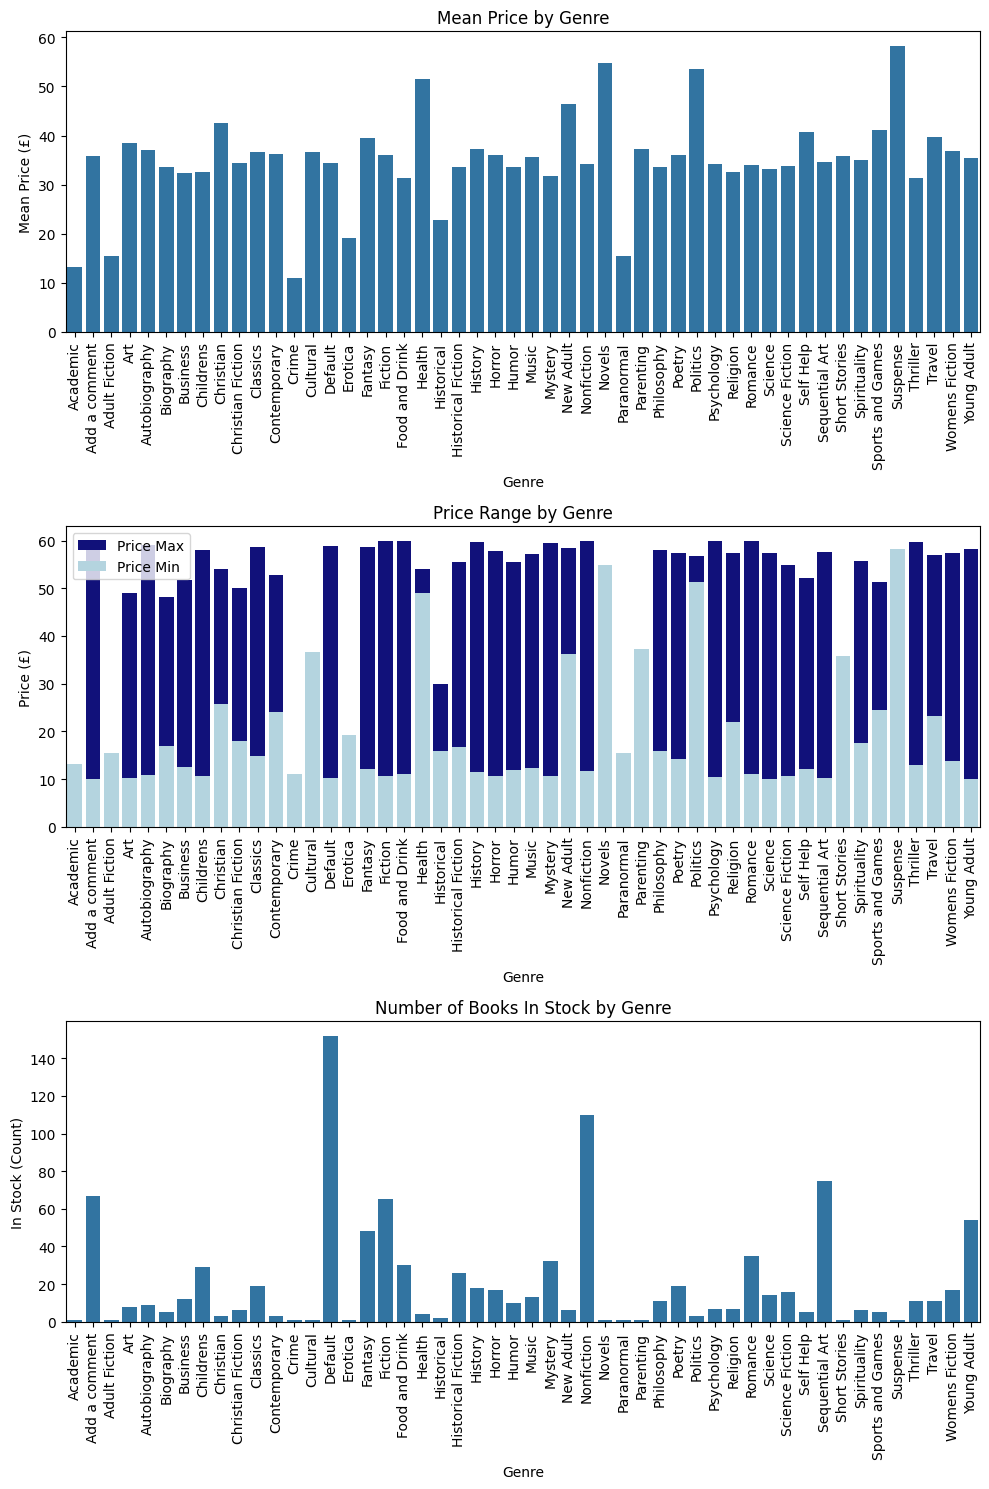

In [56]:
# Group by 'Genre' and calculate the mean of 'Price'
mean_price_by_genre = df.groupby('Genre')['Price'].mean()

# Group by 'Genre' and calculate the min and max prices for each genre
price_min_max_per_genre = df.groupby('Genre')['Price'].agg(['min', 'max']).reset_index()
price_min_max_per_genre.columns = ['Genre', 'Price Min', 'Price Max']

# Create a new column 'In Stock' where 'In stock' is assigned 1, otherwise 0
df['In Stock'] = df['Stock Status'].apply(lambda x: 1 if x == 'In stock' else 0)

# Group by 'Genre' and calculate the sum of 'In Stock' to see how many books are in stock per genre
in_stock_per_genre = df.groupby('Genre')['In Stock'].sum().reset_index()

# Merge all the calculated data into a single DataFrame for visualization
merged_data = pd.merge(price_min_max_per_genre, in_stock_per_genre, on='Genre')
merged_data['Mean Price'] = df.groupby('Genre')['Price'].mean().values

# Plot the data
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

# Plot the mean price by genre
sns.barplot(x='Genre', y='Mean Price', data=merged_data, ax=axes[0])
axes[0].set_title('Mean Price by Genre')
axes[0].set_ylabel('Mean Price (£)')
axes[0].set_xlabel('Genre')
axes[0].tick_params(axis='x', rotation=90)  # Rotate x-axis labels by 90 degrees

# Plot the price range (min and max) by genre
sns.barplot(x='Genre', y='Price Max', data=merged_data, ax=axes[1], color='darkblue', label='Price Max')
sns.barplot(x='Genre', y='Price Min', data=merged_data, ax=axes[1], color='lightblue', label='Price Min')
axes[1].set_title('Price Range by Genre')
axes[1].set_ylabel('Price (£)')
axes[1].set_xlabel('Genre')
axes[1].tick_params(axis='x', rotation=90)  # Rotate x-axis labels by 90 degrees
axes[1].legend()

# Plot the number of books in stock by genre
sns.barplot(x='Genre', y='In Stock', data=merged_data, ax=axes[2])
axes[2].set_title('Number of Books In Stock by Genre')
axes[2].set_ylabel('In Stock (Count)')
axes[2].set_xlabel('Genre')
axes[2].tick_params(axis='x', rotation=90)  # Rotate x-axis labels by 90 degrees

# Display the plots
plt.tight_layout()
plt.show()

## รายชื่อสมาชิกในกลุ่ม
| ลาดับ | ชื่อ | รหัสนิสิต |
|--------|-------------|------------------|
| 1 | อติพล เดชาติวงศ์ ณ อยุธยา | 65109010307 |
| 2 | กฤษณะ สุขจร | 65109010286 |
| 2 | ปุญญาพัฒน์ จันทะคุณ | 65109010299 |